## Doing the regressions

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
from stargazer.stargazer import Stargazer

xr.set_options(display_expand_attrs=False, display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

In [77]:
data = pd.read_csv('data.csv')
data.rename(columns={'REGIONS 35 I': 'region'}, inplace=True)
data.head()

,time,region,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,equation,total_damage,log_gross_domestic_product_nominal,log_temperature_change,log_coef,log_total_damage,damage_per_capita
0,2005.0,BELGIUM,-2.120837,14345.919289,1.714491,0.484972,0,0.845,458081.623996,24767.399895,define_tot_eq_define_total_impact,455.259577,13.034803,-0.168419,-0.723664,6.120868,6.811755e-06
1,2005.0,BULGARIA,-2.120837,14345.919289,1.714491,3.328578,0,0.845,49342.067424,4290.060541,define_tot_eq_define_total_impact,336.570307,10.806532,-0.168419,1.202545,5.818807,3.836730e-07
2,2005.0,CROATIA,-2.120837,14345.919289,1.714491,1.784685,0,0.845,49378.731850,7565.730576,define_tot_eq_define_total_impact,180.593082,10.807275,-0.168419,0.579242,5.196246,4.977241e-07
3,2005.0,CYPRUS,-2.120837,14345.919289,1.714491,0.828186,0,0.845,20251.576648,15217.411656,define_tot_eq_define_total_impact,34.370532,9.915988,-0.168419,-0.188518,3.537200,6.965997e-08
4,2005.0,CZECH REPUBLIC,-2.120837,14345.919289,1.714491,1.306405,0,0.845,186259.756742,10050.031677,define_tot_eq_define_total_impact,498.650910,12.134898,-0.168419,0.267279,6.211906,1.815622e-07


In [4]:
df_melted = pd.read_csv('df_melted.csv')
df_melted.shape

(80055, 12)

### General model

As explained in the conceptual framework, our goal here is to quantifiy how important are each factors in terms of explaining the variation of the explained variable. 

We have distinguished three types of parameters : 

- **physical parameters**, such as temperature, carbon dioxyide concentration, radiative forcing, etc. These directly represent the physical aspect of climate change
- **methodological parameters**, such as the model used, the number of variables, the level of complexity, etc. These represent parameters that rely with the model, from a technical prospective
- **ethical parameters**, such as the discount rate, the normalisation factor or other parameters that take account of ethical considerations

We argue that an integrated assessment model is composed of these three types of parameters. The role of physical variables in the functionning of the model is its primary purpose; the variation between one model and another one has been widely discussed and quantified in the litterature. However, we believe that the ethical variables play a significant role in the determination of the output of the model. 

Hence, we define an econometric model to asses the role of each of the variables in the output of the model. 

The explained variable is the level of damage. Indeed, it is the primary goal of damage functions to assess the level of damages, so we have comparable values  accros models. Moreover, it is a quantified value, so it allows a quantitative evaluation. 

We consider a linear model. The explained variables are a combination of physical, methodological and ethical variables. 

In [94]:
# Regressing
reg_simple = sm.OLS(data['total_damage'], sm.add_constant(data[['temperature_change', 'coef']])).fit()
reg_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:            total_damage   R-squared:                       0.071
Model:                             OLS   Adj. R-squared:                  0.071
Method:                  Least Squares   F-statistic:                     2743.
Date:              lun., 09 sept. 2024   Prob (F-statistic):               0.00
Time:                         14:00:02   Log-Likelihood:            -1.0655e+06
No. Observations:                71415   AIC:                         2.131e+06
Df Residuals:                    71412   BIC:                         2.131e+06
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -5.175e+05   1.02e+04    -50.537      0.000   -5.38e+05   -4.97e+05
temperature_change  3.346e+05   6291.904     53.173      0.000    3.22e+05    3.47e+05
coef                1.327e+05   2707.984     48.992      0.000    1.27e+05    1.38e+05
==============================================================================
Omnibus:                   133227.520   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        214738797.712
Skew:                          14.301   Prob(JB):                         0.00
Kurtosis:                     270.110   Cond. No.                         9.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
# Adding a dummy for the equation 
data_dummy = pd.get_dummies(data, columns=['equation'], drop_first=True)
dummy_equations = [col for col in data_dummy.columns if 'equation_' in col]
data_dummy[dummy_equations] = data_dummy[dummy_equations].astype('int')

# Adding a dummy for the region
data_dummy = pd.get_dummies(data_dummy, columns=['region'], drop_first=True)
dummy_regions = [col for col in data_dummy.columns if 'region_' in col]
data_dummy[dummy_regions] = data_dummy[dummy_regions].astype('int')

# Est-ce que c'est un problème de retirer la première valeur à chaque fois ? ca veut dire qu'on retire quand même un tiers des données => en fait non parce que les dummy sont en colonnes et pas en ligne

# Regressing
reg_equation = sm.OLS(data_dummy['total_damage'], sm.add_constant(data_dummy[['temperature_change', 'coef'] + dummy_equations])).fit()
reg_equation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:            total_damage   R-squared:                       0.073
Model:                             OLS   Adj. R-squared:                  0.073
Method:                  Least Squares   F-statistic:                     1401.
Date:              lun., 09 sept. 2024   Prob (F-statistic):               0.00
Time:                         13:59:09   Log-Likelihood:            -1.0654e+06
No. Observations:                71415   AIC:                         2.131e+06
Df Residuals:                    71410   BIC:                         2.131e+06
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                        -5.089e+05   1.09e+04    -46.531      0.000    -5.3e+05   -4.87e+05
temperature_change                            3.346e+05   6287.111     53.213      0.000    3.22e+05    3.47e+05
coef                                          1.327e+05   2705.921     49.029      0.000    1.27e+05    1.38e+05
equation_dice_tot_eq_dice_total_impact       -4.735e+04   6685.847     -7.082      0.000   -6.05e+04   -3.42e+04
equation_witness_tot_eq_witness_total_impact  2.146e+04   6685.847      3.210      0.001    8359.282    3.46e+04
==============================================================================
Omnibus:                   133172.840   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        214195336.748
Skew:                          14.289   Prob(JB):                         0.00
Kurtosis:                     269.771   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Explaining the level of damage as a linear model of temperature change, the model choice and the ethical coefficient, is a very weak explanation. We obtain a R2 of 0.073, which is very low and let us think there is absolutely no relationship between the level of damage and the explaining variables. 

This is to be further investigated, since we know there is a relationship between these two : at least, there is a relationship between climate variable such as temperature change, and the level of damage. 

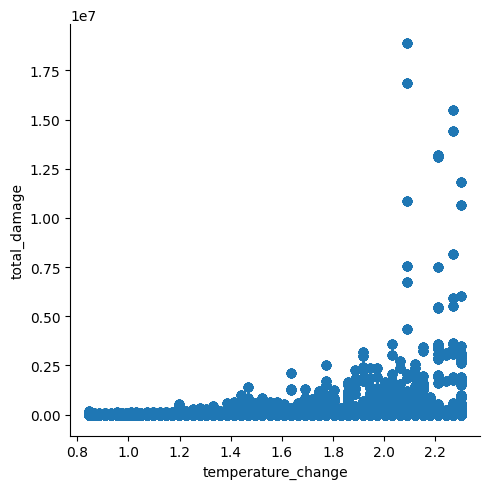

In [88]:
sns.lmplot(x='temperature_change', y='total_damage', data=data_dummy)

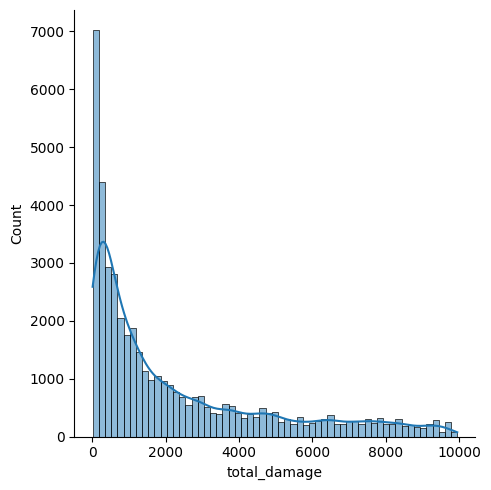

In [74]:
#damage_high = data[data['total_damage'] < 10000]
sns.displot(data=data[data['total_damage'] < 10000], x='total_damage', kde=True)

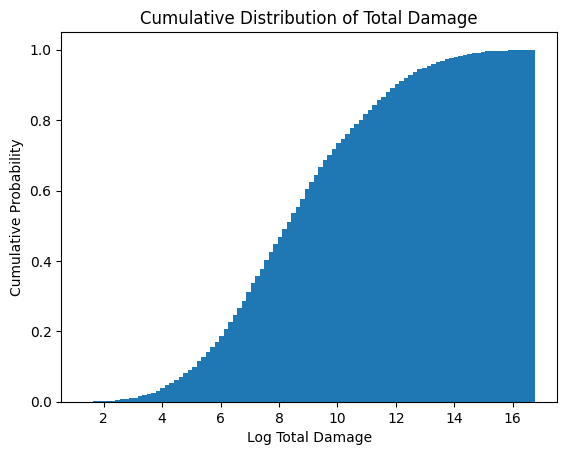

In [73]:
import matplotlib.pyplot as plt

plt.hist(data['log_total_damage'], bins=100, cumulative=True, density=True)
plt.xlabel('Log Total Damage')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Total Damage')
plt.show()

In [58]:
reg_temp = smf.ols('total_damage ~ temperature_change', data=data_dummy_equation).fit()
reg_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:            total_damage   R-squared:                       0.040
Model:                             OLS   Adj. R-squared:                  0.040
Method:                  Least Squares   F-statistic:                     2985.
Date:              lun., 09 sept. 2024   Prob (F-statistic):               0.00
Time:                         11:00:14   Log-Likelihood:            -1.0667e+06
No. Observations:                71415   AIC:                         2.133e+06
Df Residuals:                    71413   BIC:                         2.133e+06
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -3.992e+05   1.01e+04    -39.456      0.000   -4.19e+05   -3.79e+05
temperature_change  3.491e+05   6389.594     54.636      0.000    3.37e+05    3.62e+05
==============================================================================
Omnibus:                   134001.486   Durbin-Watson:                   1.521
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        220128723.233
Skew:                          14.484   Prob(JB):                         0.00
Kurtosis:                     273.441   Cond. No.                         7.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's try by having a dummy by region.

In [92]:
# Regressing
reg_country = sm.OLS(data_dummy['total_damage'], sm.add_constant(data_dummy[['temperature_change', 'coef'] + dummy_regions])).fit()
reg_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:            total_damage   R-squared:                       0.212
Model:                             OLS   Adj. R-squared:                  0.212
Method:                  Least Squares   F-statistic:                     639.6
Date:              lun., 09 sept. 2024   Prob (F-statistic):               0.00
Time:                         13:58:43   Log-Likelihood:            -1.0596e+06
No. Observations:                71415   AIC:                         2.119e+06
Df Residuals:                    71384   BIC:                         2.120e+06
Df Model:                           30                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -6.563e+05   1.64e+04    -40.003      0.000   -6.88e+05   -6.24e+05
temperature_change     3.335e+05   5800.258     57.494      0.000    3.22e+05    3.45e+05
coef                   1.335e+05   2527.884     52.817      0.000    1.29e+05    1.38e+05
region_BULGARIA        4579.1933   1.91e+04      0.239      0.811   -3.29e+04    4.21e+04
region_CHINA           1.375e+06   1.91e+04     72.182      0.000    1.34e+06    1.41e+06
region_CROATIA         2.122e+04   1.91e+04      1.113      0.266   -1.61e+04    5.86e+04
region_CYPRUS          1.674e+04   1.91e+04      0.878      0.380   -2.06e+04    5.41e+04
region_CZECH REPUBLIC  3.135e+04   1.91e+04      1.644      0.100   -6019.376    6.87e+04
region_DENMARK        -1.102e+04   1.92e+04     -0.574      0.566   -4.87e+04    2.66e+04
region_EASOC           4.425e+05   1.91e+04     23.202      0.000    4.05e+05     4.8e+05
region_ESTONIA         2.426e+04   1.91e+04      1.272      0.203   -1.31e+04    6.16e+04
region_FINLAND          975.4425   1.91e+04      0.051      0.959   -3.65e+04    3.85e+04
region_FRANCE           9.02e+04    1.9e+04      4.735      0.000    5.29e+04    1.28e+05
region_GERMANY         3.561e+05   1.95e+04     18.260      0.000    3.18e+05    3.94e+05
region_GREECE          2.356e+04   1.91e+04      1.236      0.217   -1.38e+04    6.09e+04
region_HUNGARY         1.241e+04   1.91e+04      0.651      0.515   -2.49e+04    4.98e+04
region_INDIA            3.73e+04   2.02e+04      1.850      0.064   -2217.040    7.68e+04
region_IRELAND         2.383e+04   1.91e+04      1.250      0.211   -1.35e+04    6.12e+04
region_LATAM           8.262e+04    1.9e+04      4.338      0.000    4.53e+04     1.2e+05
region_LATVIA          2.528e+04   1.91e+04      1.326      0.185   -1.21e+04    6.27e+04
region_LITHUANIA       2.936e+04   1.91e+04      1.539      0.124   -8020.456    6.67e+04
region_LROW            3.196e+05   1.94e+04     16.480      0.000    2.82e+05    3.58e+05
region_LUXEMBOURG     -3.318e+04   1.95e+04     -1.702      0.089   -7.14e+04    5024.564
region_POLAND          5.018e+04   1.91e+04      2.632      0.008    1.28e+04    8.75e+04
region_PORTUGAL        3.368e+04   1.91e+04      1.766      0.077   -3706.308    7.11e+04
region_RUSSIA           9.43e+04   1.91e+04      4.945      0.000    5.69e+04    1.32e+05
region_SLOVAKIA        2.811e+04   1.91e+04      1.474      0.141   -9269.748    6.55e+04
region_SPAIN           4.671e+04   1.91e+04      2.449      0.014    9329.404    8.41e+04
region_SWEDEN          4427.3226   1.91e+04      0.232      0.817   -3.31e+04    4.19e+04
region_UK              2.408e+05   1.95e+04     12.347      0.000    2.03e+05    2.79e+05
region_USMCA           6.755e+05   1.91e+04     35.314      0.000    6.38e+05    7.13e+05
============

Let's now try with both dummy variables for the region and for the equation. 

In [95]:
# Regressing
reg_double = sm.OLS(data_dummy['total_damage'], sm.add_constant(data_dummy[['temperature_change', 'coef'] + dummy_equations + dummy_regions])).fit()
reg_double.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:            total_damage   R-squared:                       0.213
Model:                             OLS   Adj. R-squared:                  0.213
Method:                  Least Squares   F-statistic:                     604.8
Date:              lun., 09 sept. 2024   Prob (F-statistic):               0.00
Time:                         14:00:28   Log-Likelihood:            -1.0596e+06
No. Observations:                71415   AIC:                         2.119e+06
Df Residuals:                    71382   BIC:                         2.119e+06
Df Model:                           32                                         
Covariance Type:             nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                        -6.477e+05   1.68e+04    -38.614      0.000   -6.81e+05   -6.15e+05
temperature_change                            3.335e+05   5795.036     57.546      0.000    3.22e+05    3.45e+05
coef                                          1.335e+05   2525.609     52.865      0.000    1.29e+05    1.38e+05
equation_dice_tot_eq_dice_total_impact       -4.735e+04   6159.629     -7.687      0.000   -5.94e+04   -3.53e+04
equation_witness_tot_eq_witness_total_impact  2.146e+04   6159.629      3.485      0.000    9390.668    3.35e+04
region_BULGARIA                               4579.1933   1.91e+04      0.240      0.811   -3.29e+04    4.21e+04
region_CHINA                                  1.375e+06    1.9e+04     72.247      0.000    1.34e+06    1.41e+06
region_CROATIA                                2.122e+04    1.9e+04      1.114      0.265   -1.61e+04    5.86e+04
region_CYPRUS                                 1.674e+04    1.9e+04      0.879      0.379   -2.06e+04    5.41e+04
region_CZECH REPUBLIC                         3.135e+04   1.91e+04      1.646      0.100   -5985.733    6.87e+04
region_DENMARK                               -1.102e+04   1.92e+04     -0.574      0.566   -4.86e+04    2.66e+04
region_EASOC                                  4.425e+05   1.91e+04     23.223      0.000    4.05e+05     4.8e+05
region_ESTONIA                                2.426e+04   1.91e+04      1.274      0.203   -1.31e+04    6.16e+04
region_FINLAND                                 975.4425   1.91e+04      0.051      0.959   -3.65e+04    3.84e+04
region_FRANCE                                  9.02e+04    1.9e+04      4.739      0.000    5.29e+04    1.27e+05
region_GERMANY                                3.561e+05   1.95e+04     18.276      0.000    3.18e+05    3.94e+05
region_GREECE                                 2.356e+04    1.9e+04      1.237      0.216   -1.38e+04    6.09e+04
region_HUNGARY                                1.241e+04    1.9e+04      0.652      0.514   -2.49e+04    4.97e+04
region_INDIA                                   3.73e+04   2.01e+04      1.852      0.064   -2181.472    7.68e+04
region_IRELAND                                2.383e+04    1.9e+04      1.251      0.211   -1.35e+04    6.12e+04
region_LATAM                                  8.262e+04    1.9e+04      4.342      0.000    4.53e+04     1.2e+05
region_LATVIA                                 2.528e+04   1.91e+04      1.327      0.185   -1.21e+04    6.26e+04
region_LITHUANIA                              2.936e+04   1.91e+04      1.541      0.123   -7986.804    6.67e+04
region_LROW                                   3.196e+05   1.94e+04     16.495      0.000    2.82e+05    3.58e+05
region_LUXEMBOURG    

To the table.

In [107]:
# Creating the stargazer object
stargazer = Stargazer([reg_simple, reg_equation, reg_country, reg_double])

# Customizing the table
stargazer.title('Résultats de la régression')
stargazer.show_model_numbers(False)
stargazer.cov_spacing = 2

# Showing everthing except countries
variables_to_show = ['temperature_change', 'coef'] + dummy_equations
stargazer.covariate_order(variables_to_show)

# Customizing the columns and lines titles
stargazer.custom_columns(['Simple', 'Equation', 'Country', 'Double'], [1, 1, 1, 1])
stargazer.rename_covariates({'temperature_change': 'Temperature Change',
                              'coef': 'Ethical coefficient', 
                              'equation': 'Model',
                              'region': 'Region', 
                              'equation_dice_tot_eq_dice_total_impact': 'DICE form damage function',
                              'equation_witness_tot_eq_witness_total_impact': 'WITNESS form damage function',})


stargazer.add_line('Regional dummy', ['No', 'No', 'Yes', 'Yes'])



# Rendering to latex to include in the report
latex_code=stargazer.render_latex()
latex_code = latex_code.replace('_', r'\_')

# Saving it to the report folder
with open('../../../../Memoire/results/reg.tex', 'w') as f:
    f.write(latex_code)

# Showing the table
stargazer


### Explaining each region x time value by the choice of the model, temperature and the choice of the coefficient

Here, we test a very straight-forward model that explains the level of damage by a few straight-forward variables : 

$$

\text{Damage}_{t,r} = \beta_0 + \beta_1 \cdot GDP_{t,r} + \beta_2 \cdot \text{Temperature change} + \beta_3 \cdot coef_{t,r}
 
$$

By trials and mistake, we have come to the conclusion that using log_total_damage was a better use. In fact, it appears that this is just re-writting the same equation differently. 

$$

\begin{align*}
& D_{t,r} = f(\text{temperature}, \text{other drivers})_{t,r} \cdot GDP_{t,r} \cdot (\frac{y_{t,r}}{y_0})^\alpha \\
\iff  & D_{t,r} = \text{temperature}_{t,r}^{\beta_1} \cdot GDP_{t,r}^{\beta_2} \cdot \text{coef}^{\beta_3} \\
\iff & log(D_{t,r}) = log(\text{temperature}_{t,r}^{\beta_1} \cdot GDP_{t,r}^{\beta_2} \cdot \text{coef}^{\beta_3}) \\
\iff & log(D_{t,r}) = \beta_1 \cdot log(\text{temperature}_{t,r}) + \beta_2 \cdot log(GDP_{t,r}) + \beta_3 \cdot log(\text{coef})
\end{align*}

$$


In [5]:
regression_simple = sm.OLS(data['log_total_damage'], sm.add_constant(data[['log_temperature_change', 'log_coef', 'log_gross_domestic_product_nominal']])).fit()
regression_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_total_damage   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.294e+06
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:41:41   Log-Likelihood:                -7402.9
No. Observations:               71415   AIC:                         1.481e+04
Df Residuals:                   71411   BIC:                         1.485e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -5.5893      0.006   -876.726      0.000      -5.602      -5.577
log_temperature_change                 2.2738      0.004    648.482      0.000       2.267       2.281
log_coef                               0.9983      0.001   1159.131      0.000       0.997       1.000
log_gross_domestic_product_nominal     1.0016      0.000   2092.325      0.000       1.001       1.003
==============================================================================
Omnibus:                   411603.444   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8553.824
Skew:                           0.377   Prob(JB):                         0.00
Kurtosis:                       1.482   Cond. No.                         87.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We find a R-squared coefficient of 0.990, which means that the variables we take into account explain 99% of the variability of the level of climate damage. This is consistent with the way the climate damages have been designed : they are precisely a combination of temperature, GDP and the coef. We have linearized the function, which was a product, by passing it through the log function. 

In [6]:
data['total_damage'].corr(data['coef'])

0.18592763695403167

<Axes: xlabel='log_gross_domestic_product_nominal', ylabel='log_total_damage'>

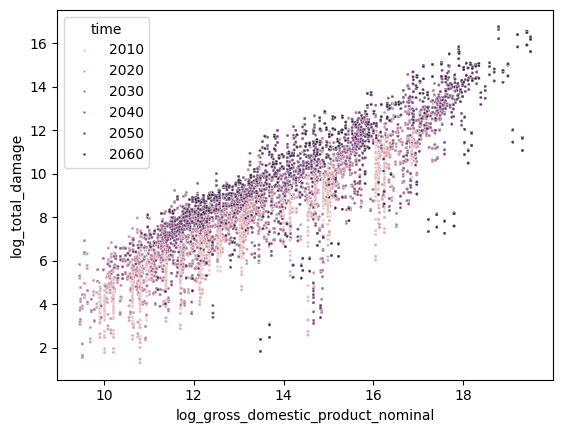

In [7]:
sns.scatterplot(data=data, x='log_gross_domestic_product_nominal', y='log_total_damage', hue='time', s=3)

### As aggregated data by country

Now, the thing we are being interested in is the global level of damage. Indeed, that is the metric used by SCC specialists to compute the optimal level of carbon emissions and the associated Social Cost of Carbon. 

We'll use the same dataset and sum the damages by year for every region, in order to have a global level of damage for every year. These levels of damage will be differentiated by their coef, the temperature change associated with it. 

We will then compute the following model : 

$$

\text{Global damage} = \beta_0 + \beta_1 \cdot \text{temperature change} + \beta_2 \cdot \text{coef}

$$

In [8]:
data_global = data.groupby(['time', 'equation', 'coef', 'temperature_change']).agg({'total_damage':'sum', 'gross_domestic_product_nominal': 'sum'}).reset_index()
data_global = pd.get_dummies(data_global, columns=['equation'])
data_global["decade"] = (data_global["time"] // 10 *10)

data_global

,time,coef,temperature_change,total_damage,gross_domestic_product_nominal,equation_define_tot_eq_define_total_impact,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact,decade
0,2005.0,0.221798,0.845000,3.893736e+02,8.566627e+05,True,False,False,2000.0
1,2005.0,0.366073,0.845000,3.269952e+04,4.358873e+07,True,False,False,2000.0
2,2005.0,0.370103,0.845000,2.379109e+05,3.136840e+08,True,False,False,2000.0
3,2005.0,0.413845,0.845000,3.773318e+03,4.449244e+06,True,False,False,2000.0
4,2005.0,0.443601,0.845000,6.766947e+03,7.443897e+06,True,False,False,2000.0
...,...,...,...,...,...,...,...,...,...
4756,2060.0,1.159320,2.301589,1.426049e+06,3.792619e+07,False,False,True,2060.0
4757,2060.0,1.170112,2.301589,1.224897e+06,3.227606e+07,False,False,True,2060.0
4758,2060.0,1.207024,2.301589,2.615214e+07,6.680356e+08,False,False,True,2060.0
4759,2060.0,1.225088,2.301589,3.956468e+07,9.957464e+08,False,False,True,2060.0


In [9]:

data_global["decade"] = (data_global["time"] // 10 *10)

y =  np.log(data_global['total_damage'])
X = data_global[['coef' , 'equation_define_tot_eq_define_total_impact',  'equation_witness_tot_eq_witness_total_impact']]

X = X.astype(float)



regression_global = sm.OLS(y, sm.add_constant(X)).fit() 
regression_global.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     253.3
Date:                Mon, 09 Sep 2024   Prob (F-statistic):          1.75e-152
Time:                        09:41:44   Log-Likelihood:                -11040.
No. Observations:                4761   AIC:                         2.209e+04
Df Residuals:                    4757   BIC:                         2.211e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            9.9989      0.072    138.508      0.000       9.857      10.140
coef                                             0.9443      0.035     26.744      0.000       0.875       1.013
equation_define_tot_eq_define_total_impact       0.0684      0.087      0.783      0.434      -0.103       0.240
equation_witness_tot_eq_witness_total_impact     0.5355      0.087      6.131      0.000       0.364       0.707
==============================================================================
Omnibus:                       81.522   Durbin-Watson:                   1.357
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.801
Skew:                           0.224   Prob(JB):                     1.89e-15
Kurtosis:                       2.624   Cond. No.                         5.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Same taking into account the time : higher R squared, but strong collinearity. 

In [10]:
y =  np.log(data_global['total_damage'])
X = data_global[['time', 'coef' , 'equation_define_tot_eq_define_total_impact',  'equation_witness_tot_eq_witness_total_impact']]

X = X.astype(float)



regression_global = sm.OLS(y, sm.add_constant(X)).fit() 
regression_global.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     551.6
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:41:44   Log-Likelihood:                -10485.
No. Observations:                4761   AIC:                         2.098e+04
Df Residuals:                    4756   BIC:                         2.101e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                         -130.9058      3.990    -32.807      0.000    -138.728    -123.083
time                                             0.0694      0.002     35.318      0.000       0.066       0.073
coef                                             0.8882      0.031     28.226      0.000       0.827       0.950
equation_define_tot_eq_define_total_impact       0.0684      0.078      0.880      0.379      -0.084       0.221
equation_witness_tot_eq_witness_total_impact     0.5355      0.078      6.888      0.000       0.383       0.688
==============================================================================
Omnibus:                      214.154   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.562
Skew:                           0.194   Prob(JB):                     9.81e-25
Kurtosis:                       2.362   Cond. No.                     2.56e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: xlabel='coef', ylabel='total_damage'>

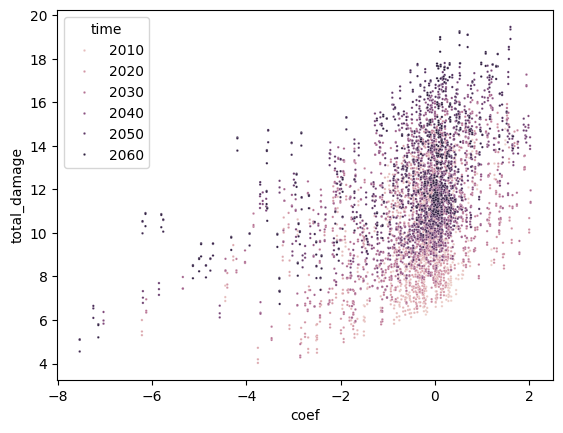

In [11]:
sns.scatterplot(data=data_global, x=np.log(data_global['coef']), y=np.log(data_global['total_damage']), s=3, hue='time')

<Axes: xlabel='time', ylabel='total_damage'>

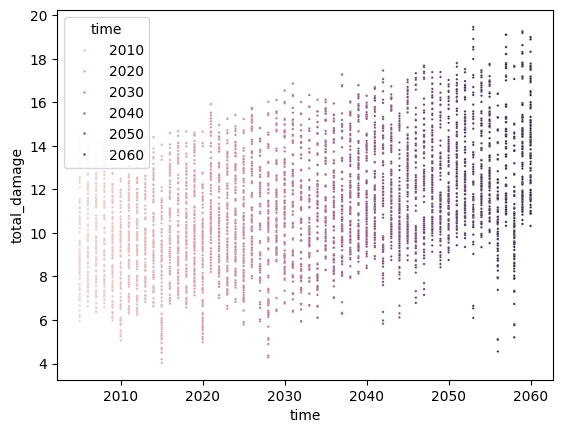

In [12]:
sns.scatterplot(data= data_global, x='time',  y=np.log(data_global['total_damage']), s=3, hue='time')

### Without the equation dummies

In [13]:
# Group by time, region, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()

# Create a dummy for each damage function
#df_regression = pd.get_dummies(df_regression, columns=['equation'], drop_first=False)

# Drop the null values
df_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
df_regression = df_regression.dropna()

# Define the dependant variable and the independant variables
y = df_regression['total_damage']
X = df_regression.drop(columns=['total_damage', 'REGIONS 35 I', 'equation', 'coef'], axis=1)

# Add a constant to the independant variables
X = sm.add_constant(X)

# Convert the data to float
X = X.astype(float)
y = y.astype(float)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     1172.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:41:45   Log-Likelihood:                -41233.
No. Observations:                2520   AIC:                         8.248e+04
Df Residuals:                    2511   BIC:                         8.254e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                -6.595e+08    2.6e+08     -2.540      0.011   -1.17e+09    -1.5e+08
time                                  3.373e+05   1.32e+05      2.558      0.011    7.87e+04    5.96e+05
extra_extra_exponent                 -1.471e+05   6.08e+04     -2.421      0.016   -2.66e+05    -2.8e+04
extra_extra_normalisation_constant     -12.0493      5.421     -2.223      0.026     -22.679      -1.420
total_radiative_forcing              -1.218e+07   2.84e+06     -4.296      0.000   -1.77e+07   -6.62e+06
Run                                   -320.2881    446.436     -0.717      0.473   -1195.708     555.131
temperature_change                    8.044e+04   1.31e+04      6.159      0.000    5.48e+04    1.06e+05
gross_domestic_product_nominal           0.1419      0.003     55.278      0.000       0.137       0.147
average_disposable_income_per_capita   -15.4955      0.348    -44.536      0.000     -16.178     -14.813
==============================================================================
Omnibus:                      533.953   Durbin-Watson:                   1.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5897.620
Skew:                           0.675   Prob(JB):                         0.00
Kurtosis:                      10.372   Cond. No.                     1.06e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

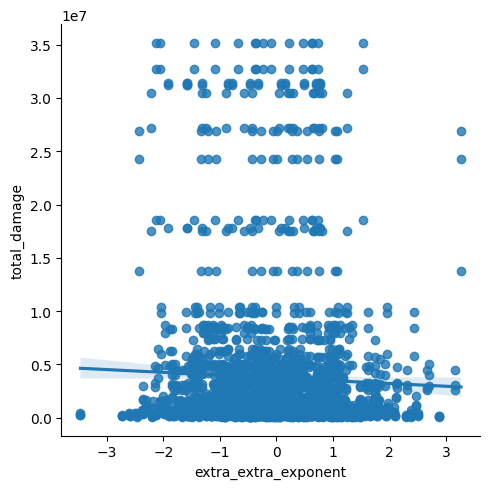

In [14]:
sns.lmplot(data=df_regression, x='extra_extra_exponent', y='total_damage')

### Without countries as dummy

In [15]:
# Group by time, region, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()

# Create a dummy for each damage function
df_regression = pd.get_dummies(df_regression, columns=['equation'], drop_first=True)

# Drop the null values
df_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
df_regression = df_regression.dropna()

# Define the dependant variable and the independant variables
y = df_regression['total_damage']
X = df_regression.drop(columns=['total_damage', 'REGIONS 35 I', 'time', 'extra_extra_normalisation_constant', 'extra_extra_exponent', 'gross_domestic_product_nominal', 'average_disposable_income_per_capita', 'Run', 'temperature_change'], axis=1)

# Add a constant to the independant variables
X = sm.add_constant(X)

# Convert the data to float
X = X.astype(float)
y = y.astype(float)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     501.0
Date:                Mon, 09 Sep 2024   Prob (F-statistic):          5.34e-318
Time:                        09:41:45   Log-Likelihood:                -42454.
No. Observations:                2520   AIC:                         8.492e+04
Df Residuals:                    2515   BIC:                         8.495e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                        -1.489e+07   4.67e+05    -31.906      0.000   -1.58e+07    -1.4e+07
total_radiative_forcing                       5.346e+06   1.31e+05     40.711      0.000    5.09e+06     5.6e+06
coef                                          9.898e+04   7328.425     13.507      0.000    8.46e+04    1.13e+05
equation_dice_tot_eq_dice_total_impact       -1.342e+06   2.45e+05     -5.479      0.000   -1.82e+06   -8.62e+05
equation_witness_tot_eq_witness_total_impact  6.083e+05   2.45e+05      2.484      0.013    1.28e+05    1.09e+06
==============================================================================
Omnibus:                     1302.833   Durbin-Watson:                   0.355
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7894.563
Skew:                           2.452   Prob(JB):                         0.00
Kurtosis:                      10.151   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# Creating the stargazer object
stargazer = Stargazer([results])

# Customizing the table
stargazer.title('Résultats de la régression')
stargazer.show_model_numbers(False)

latex_code=stargazer.render_latex()

latex_code = latex_code.replace('_', r'\_')


with open('../../../../Memoire/results/reg.tex', 'w') as f:
    f.write(latex_code)


In [17]:
df_regression

,time,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,REGIONS 35 I,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,total_damage,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact
0,2005.0,-2.499737,37291.354076,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,35.992621,364,23.660000,6.946382e+07,4.609016e+05,2.210159e+05,False,False
1,2005.0,-2.499737,37291.354076,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,35.992621,364,23.660000,6.946382e+07,4.609016e+05,2.669876e+05,True,False
2,2005.0,-2.499737,37291.354076,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,35.992621,364,23.660000,6.946382e+07,4.609016e+05,4.511240e+05,False,True
3,2005.0,-2.483093,48301.730067,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,35.992621,224,23.660000,6.946382e+07,4.609016e+05,2.210159e+05,False,False
4,2005.0,-2.483093,48301.730067,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,35.992621,224,23.660000,6.946382e+07,4.609016e+05,2.669876e+05,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2060.0,1.071663,33617.864179,4.301696,AUSTRIABELGIUMBULGARIACROATIACYPRUSCZECH REPUB...,30.702805,35,80.555617,7.187911e+08,4.298371e+06,1.373452e+07,True,False
2516,2060.0,1.071663,33617.864179,4.301696,AUSTRIABELGIUMBULGARIACROATIACYPRUSCZECH REPUB...,30.702805,35,80.555617,7.187911e+08,4.298371e+06,2.425469e+07,False,True
2517,2060.0,3.259974,18841.706602,4.301696,AUSTRIABELGIUMBULGARIACROATIACYPRUSCZECH REPUB...,30.702805,385,80.555617,7.187911e+08,4.298371e+06,2.691910e+07,False,False
2518,2060.0,3.259974,18841.706602,4.301696,AUSTRIABELGIUMBULGARIACROATIACYPRUSCZECH REPUB...,30.702805,385,80.555617,7.187911e+08,4.298371e+06,1.373452e+07,True,False


### With countries as dummy

In [18]:
# Group by time, region, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'REGIONS 35 I', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()

# Create a dummy for each damage function
df_regression = pd.get_dummies(df_regression, columns=['equation', 'REGIONS 35 I'], drop_first=True)

# Drop the null values
df_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
df_regression = df_regression.dropna()

# Define the dependant variable and the independant variables
y = df_regression['total_damage']
X = df_regression.drop(columns=['total_damage'], axis=1)

# Add a constant to the independant variables
X = sm.add_constant(X)

# Convert the data to float
X = X.astype(float)
y = y.astype(float)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     2217.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:41:46   Log-Likelihood:            -1.1605e+06
No. Observations:               80055   AIC:                         2.321e+06
Df Residuals:                   80009   BIC:                         2.322e+06
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                         7.927e+06   6.47e+06      1.226      0.220   -4.75e+06    2.06e+07
time                                         -3913.1080   3282.913     -1.192      0.233   -1.03e+04    2521.381
extra_extra_exponent                          -371.3995   1662.053     -0.223      0.823   -3629.013    2886.214
extra_extra_normalisation_constant              -0.1548      0.149     -1.040      0.298      -0.447       0.137
total_radiative_forcing                      -5.479e+05   9.25e+04     -5.925      0.000   -7.29e+05   -3.67e+05
coef                                          1.329e+05   1805.450     73.636      0.000    1.29e+05    1.36e+05
Run                                             -3.9958    391.225     -0.010      0.992    -770.794     762.803
temperature_change                            1.068e+06   1.12e+05      9.575      0.000     8.5e+05    1.29e+06
gross_domestic_product_nominal                   0.0315      0.000    241.583      0.000       0.031       0.032
average_disposable_income_per_capita             0.2993      0.036      8.308      0.000       0.229       0.370
equation_dice_tot_eq_dice_total_impact       -4.224e+04   4139.893    -10.203      0.000   -5.04e+04   -3.41e+04
equation_witness_tot_eq_witness_total_impact  1.915e+04   4139.893      4.625      0.000     1.1e+04    2.73e+04
REGIONS 35 I_BELGIUM                         -1.769e+05   1.62e+04    -10.902      0.000   -2.09e+05   -1.45e+05
REGIONS 35 I_BULGARIA                        -1.096e+05    1.6e+04     -6.863      0.000   -1.41e+05   -7.83e+04
REGIONS 35 I_CHINA                            -6.91e+05   1.77e+04    -39.033      0.000   -7.26e+05   -6.56e+05
REGIONS 35 I_CROATIA                         -9.551e+04   1.59e+04     -6.008      0.000   -1.27e+05   -6.44e+04
REGIONS 35 I_CYPRUS                          -1.006e+05   1.59e+04     -6.322      0.000   -1.32e+05   -6.94e+04
REGIONS 35 I_CZECH REPUBLIC                  -1.008e+05   1.59e+04     -6.337      0.000   -1.32e+05   -6.96e+04
REGIONS 35 I_DENMARK                         -1.704e+05   1.63e+04    -10.449      0.000   -2.02e+05   -1.38e+05
REGIONS 35 I_EASOC                           -5.551e+05   1.62e+04    -34.178      0.000   -5.87e+05   -5.23e+05
REGIONS 35 I_ESTONIA                         -9.472e+04   1.59e+04     -5.953      0.000   -1.26e+05   -6.35e+04
REGIONS 35 I_FINLAND                           -1.5e+05   1.62e+04     -9.273      0.000   -1.82e+05   -1.18e+05
REGIONS 35 I_FRANCE                          -1.851e+05    1.6e+04    -11.584      0.000   -2.16e+05   -1.54e+05
REGIONS 35 I_GERMANY                         -2.563e+05   1.68e+04    -15.282      0.000   -2.89e+05   -2.23e+05
REGIONS 35 I_GREECE             

### Exporting to $\LaTeX$

In [19]:
stargazer = Stargazer([results])
stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{1}{c}{\\textit{Dependent variable: total_damage}} \\\n\\cr \\cline{2-2}\n\\\\[-1.8ex] & (1) \\\\\n\\hline \\\\[-1.8ex]\n REGIONS 35 I_BELGIUM & -176915.888$^{***}$ \\\\\n& (16228.153) \\\\\n REGIONS 35 I_BULGARIA & -109613.777$^{***}$ \\\\\n& (15970.847) \\\\\n REGIONS 35 I_CHINA & -691024.091$^{***}$ \\\\\n& (17703.490) \\\\\n REGIONS 35 I_CROATIA & -95511.508$^{***}$ \\\\\n& (15898.409) \\\\\n REGIONS 35 I_CYPRUS & -100617.448$^{***}$ \\\\\n& (15916.282) \\\\\n REGIONS 35 I_CZECH REPUBLIC & -100822.888$^{***}$ \\\\\n& (15910.776) \\\\\n REGIONS 35 I_DENMARK & -170358.399$^{***}$ \\\\\n& (16303.587) \\\\\n REGIONS 35 I_EASOC & -555110.591$^{***}$ \\\\\n& (16241.764) \\\\\n REGIONS 35 I_ESTONIA & -94719.224$^{***}$ \\\\\n& (15910.609) \\\\\n REGIONS 35 I_FINLAND & -150040.144$^{***}$ \\\\\n& (16179.774) \\\\\n REGIONS 35 I_FRANCE & -185097.091$^{***}